In [2]:
import networkx as nx
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely
import snkit
import snkit.network
import igraph as ig
from ast import literal_eval
import math 
import numpy as np
crs_fr = 4326
plt.rcParams['figure.figsize'] = (10, 10)

In [3]:
# Check function
def check_missing_nodes(set11, set12, node_IDs):
    set11 = set(set11)
    set12 = set(set12)
    node_IDs = set(node_IDs)
    IDs_in_edges = set11.union(set12)
    missing = list(sorted(IDs_in_edges - node_IDs))
    added = list(sorted(node_IDs - IDs_in_edges))
    return(missing, added)

In [4]:
# --- From Anastassia
# import packages
%run -i packages.py

# CUSTOM FUNCTIONS

# define function that creates attribute dictionary for nodes and edges
# (for input to nx.add_edges_from/add_nodes_from)
def make_attr_dict(*args, **kwargs): 
    
    argCount = len(kwargs)
    
    if argCount > 0:
        attributes = {}
        for kwarg in kwargs:
            attributes[kwarg] = kwargs.get(kwarg, None)
        return attributes
    else:
        return None # (if no attributes are given)
    
# computes pathlength by nx - handling error message if nodes are not connected/not part of the network
def pathlength_if_connected(my_nw, my_o, my_d):
    try:
        return(nx.dijkstra_path_length(my_nw, my_o, my_d, weight = "length"))
    except:
        return(math.inf)
    
# get list of edge coordinates for plotting from list of nx edge ids:
def get_path_coords(my_path, my_coorddict):
    pathcoords = []
    for edge_id in my_path:
        edge_coords = [(c[1], c[0]) for c in my_coorddict[tuple(sorted(edge_id))].coords]
        pathcoords.append(edge_coords)
    return(pathcoords) 

# Create complete network
- get all layers created so far (IRIS, centroids, roads for cars and bikes, public transport layer(s))

- connect centroids to the carbike network: 
    - combine centroids and carbike nodes into one nodes_network dataframe
    - put the combined nodes and the carbike edges into snkit
    - create a base_network with them, create a linked network
    - go back to separate carbike and centroid dataframes as needed



## Get layers

In [6]:
# Get boundary of GPM (for plots)
GPM = gpd.read_file('data/raw/GPM_geometry/GPM.geojson').to_crs(crs_fr)

### Centroids

In [5]:
# Get grid and centroids
grid = gpd.read_file('data/raw/IRIS_GPM.geojson')

# turn into geodataframe and separate centroids 
grid['centroid'] = grid.centroid
centroids = grid.drop(columns = 'geometry').rename(columns = {'centroid':'geometry'}).set_geometry('geometry').to_crs(2154)


# Adding necessary attributes for the network
centroids['nodetype'] = 'both'
centroids['centroid'] = True
centroids['RER'] = False

# Make a new dataframe for the network just in case TODO move to the nextwork building cell 
centroids_network = centroids.to_crs(crs_fr)
centroids_network['x'] = centroids_network['geometry'].x
centroids_network['y'] = centroids_network['geometry'].y

centroids_network


CODE_IRIS                  geometry nodetype  centroid    RER         x  \
0     920440109  POINT (2.28928 48.89521)     both      True  False  2.289280   
1     930270105  POINT (2.40273 48.92223)     both      True  False  2.402726   
2     751197316  POINT (2.37442 48.89225)     both      True  False  2.374425   
3     751176716  POINT (2.30742 48.88866)     both      True  False  2.307418   
4     920020104  POINT (2.31126 48.76564)     both      True  False  2.311259   
...         ...                       ...      ...       ...    ...       ...   
2661  930290203  POINT (2.45812 48.92539)     both      True  False  2.458119   
2662  920070111  POINT (2.31503 48.79468)     both      True  False  2.315035   
2663  930050101  POINT (2.48084 48.94737)     both      True  False  2.480841   
2664  920190113  POINT (2.27666 48.76719)     both      True  False  2.276657   
2665  930010501  POINT (2.39441 48.91240)     both      True  False  2.394411   

              y  
0     48.895206  
1     48.922227  
2     48.892245  
3     48.888659  
4     48.765645  
...         ...  
2661  48.925392  
2662  48.794683  
2663  48.947369  
2664  48.767193  
2665  48.912402  

[2666 rows x 7 columns]

### roads 

In [6]:
# Get roads (car/bike, nodes/edges)
edges_carbike = pd.read_csv("./data/processed/carbike_edges_bothtype.csv")
nodes_carbike = pd.read_csv("./data/processed/carbike_nodes_bothtype.csv")

In [7]:
#--- Getting the nodes ready for the network

# Add attributes
nodes_carbike['centroid'] = False
nodes_carbike['RER'] = False    

# Turn into GeoDataFrame
nodes_carbike["geometry"] = nodes_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike = gpd.GeoDataFrame(nodes_carbike, geometry = 'geometry', crs = crs_fr)

# Re-create x and y columns
nodes_carbike['x'] = nodes_carbike['geometry'].x
nodes_carbike['y'] = nodes_carbike['geometry'].y


In [8]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

In [9]:
# Turn to GeoDataFrame
edges_carbike["geometry"] = edges_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike = gpd.GeoDataFrame(edges_carbike, geometry = "geometry", crs = crs_fr) 

In [10]:
check_missing_nodes(edges_carbike['x'], edges_carbike['y'], nodes_carbike['osmid'])

([], [])

#### Find biggest connected component and only work with that

In [11]:
#--- Checking for connectedness 

# Create Networkx Graph
G1 = nx.from_pandas_edgelist(edges_carbike, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
# G1.add_nodes_from(nodes.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
G1.add_nodes_from(nodes_carbike.loc[:,"osmid"])

# Find disconnected components
S1 = [G1.subgraph(c).copy() for c in nx.weakly_connected_components(G1)] 

#--- Compute some statistics
graph_below_2_nodes = 0
graph_above_2_nodes = 0
big_graph = 0

lengthlist = []
for index in range(len(S1)):
    lengthlist.append(len(S1[index]))
    if len(S1[index]) < 3 :
        graph_below_2_nodes+=1
    elif len(S1[index]) > 100 :
        big_graph +=1
    else:
        graph_above_2_nodes+=1

lengthS1 = 0
for edge in S1[0].edges:
    lengthS1 += edges_carbike.loc[(edges_carbike['x'] == edge[0]) & (edges_carbike['y'] == edge[1]), 'length'].values[0]

# Print the statistics
print("disconnected components with 2 nodes or less ", graph_below_2_nodes)
print("disconnected components with 3 or more nodes, less than 100", graph_above_2_nodes)
print("disconnected components with 100 or more nodes", big_graph)
print("total number of disconnected components", len(S1))
print("Percentage of edges in the largest component", len(S1[0]) / len(edges_carbike) * 100) 
print("Percentage of km of edges in the largest component", lengthS1 / edges_carbike['length'].sum() * 100)

disconnected components with 2 nodes or less  592
disconnected components with 3 or more nodes, less than 100 140
disconnected components with 100 or more nodes 1
total number of disconnected components 733
Percentage of edges in the largest component 55.75114243133075
Percentage of km of edges in the largest component 72.00105177294279


In [12]:
#--- Only work with the largest connected component

# Make the largest connected component undirected
H = S1[0].to_undirected()

# Export the edges of the graph to a pandas dataframe
edges_carbike_connected = nx.to_pandas_edgelist(H, source='x', target='y')
# edges_carbike_connected["geometry"] = edges_carbike_connected.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike_connected = gpd.GeoDataFrame(edges_carbike_connected, geometry = 'geometry', crs = crs_fr)

# Filter the nodes dataframe to only include the nodes that are in the largest connected component
nodes_carbike_connected = nodes_carbike.loc[nodes_carbike['osmid'].isin(edges_carbike_connected['x']) | nodes_carbike['osmid'].isin(edges_carbike_connected['y'])]

In [13]:
# Check if the resulting network is connected 
G2 = nx.from_pandas_edgelist(edges_carbike_connected, source='x', target='y', edge_attr=True, create_using=nx.DiGraph)
# G1.add_nodes_from(nodes.loc[:,["osmid", "attr_dict"]].itertuples(index = False))
G2.add_nodes_from(nodes_carbike_connected.loc[:,"osmid"])

# Find disconnected components
S2 = [G2.subgraph(c).copy() for c in nx.weakly_connected_components(G2)] 
print(len(S2))
H = S2[0].to_undirected()
print(nx.is_connected(H))


1
True


In [14]:
# # Plot

# ax = plt.axes()
# edges_carbike_connected.plot(ax=ax, linewidth = 0.3, alpha = 0.5)
# nodes_carbike_connected.plot(ax=ax, markersize = 0.05, facecolor = 'red', alpha = 1)
# GPM.plot(ax=ax, facecolor = 'none', linewidth = 2)

### RER and Metro (not relevant anymore)

In [15]:
# #--- Get data
# RER_stations = pd.read_csv("./data/processed/RER_stations.csv")
# RER_lines = pd.read_csv("./data/processed/RER_lines.csv")

In [16]:
# check_missing_nodes(RER_lines.x, RER_lines.y, RER_stations.id) 

In [17]:
# #--- Add necessary attributes

# # For lines
# RER_lines['edgetype'] = 'RER'

# # For stations
# RER_stations['nodetype'] = 'bike'
# RER_stations['centroid'] = False
# RER_stations['RER'] = True
# RER_stations = RER_stations.rename(columns = {'id': 'osmid'})

In [18]:
# #--- turn to GeoDataFrame
# RER_stations["geometry"] = RER_stations.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
# RER_stations = gpd.GeoDataFrame(RER_stations, geometry = 'geometry', crs = 2154).to_crs(crs_fr)
# RER_lines["geometry"] = RER_lines.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
# RER_lines = gpd.GeoDataFrame(RER_lines, geometry = 'geometry', crs = 2154).to_crs(crs_fr)


## Connect carbike edges, centroids and RER stations
A network is created with
- nodes = centroids, RER stops and road intersections
- edges = roads

These edges and nodes will be connected by creating an edge between each centroid/RER station and its nearest carbike edge. The intersection between the new edge and the old edge will become a new node, and the old edge will be split into two new edges. 

In [19]:
#--- Create dataframe with all carbike nodes and centroids 

# with
nodes_network = pd.concat([centroids_network, nodes_carbike_connected])#RER_stations (put first if using the RER stuff too)

In [20]:
nodes_network[nodes_network['centroid'] == True]

# If 2066, we're good to go

CODE_IRIS                  geometry nodetype  centroid    RER         x  \
0     920440109  POINT (2.28928 48.89521)     both      True  False  2.289280   
1     930270105  POINT (2.40273 48.92223)     both      True  False  2.402726   
2     751197316  POINT (2.37442 48.89225)     both      True  False  2.374425   
3     751176716  POINT (2.30742 48.88866)     both      True  False  2.307418   
4     920020104  POINT (2.31126 48.76564)     both      True  False  2.311259   
...         ...                       ...      ...       ...    ...       ...   
2661  930290203  POINT (2.45812 48.92539)     both      True  False  2.458119   
2662  920070111  POINT (2.31503 48.79468)     both      True  False  2.315035   
2663  930050101  POINT (2.48084 48.94737)     both      True  False  2.480841   
2664  920190113  POINT (2.27666 48.76719)     both      True  False  2.276657   
2665  930010501  POINT (2.39441 48.91240)     both      True  False  2.394411   

              y  osmid  
0     48.895206    NaN  
1     48.922227    NaN  
2     48.892245    NaN  
3     48.888659    NaN  
4     48.765645    NaN  
...         ...    ...  
2661  48.925392    NaN  
2662  48.794683    NaN  
2663  48.947369    NaN  
2664  48.767193    NaN  
2665  48.912402    NaN  

[2666 rows x 8 columns]

In [21]:
#--- Creating the network 

# Nodes 
nodes = gpd.GeoDataFrame(nodes_network, geometry = "geometry", crs = crs_fr)

# Edges
edges = edges_carbike_connected

# Network
base_network = snkit.Network(nodes, edges)

# # Plot
# ax = plt.axes()
# base_network.edges.plot(ax=ax, linewidth = 1, alpha = 0.6)
# base_network.nodes.plot(ax=ax, facecolor = 'red', markersize = 3)

In [22]:
nodes.head(1)

CODE_IRIS                  geometry nodetype  centroid    RER        x  \
0  920440109  POINT (2.28928 48.89521)     both      True  False  2.28928   

           y  osmid  
0  48.895206    NaN

In [23]:
edges.head(1)

x          y                                           geometry  \
0  122926  318399738  LINESTRING (2.46355 48.88408, 2.46236 48.88415...   

   length              edge_id edgetype  
0  1618.6  [122926, 318399738]      car

In [24]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from base_network
G = nx.from_pandas_edgelist(base_network.edges, source='x', target='y', edge_attr=True)

# Need to filter for carbike nodes since RER and centroids are obviously not connected 
G.add_nodes_from(base_network.nodes.loc[(base_network.nodes['centroid'] == False) & (base_network.nodes['RER'] == False)]['osmid'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))


True


In [25]:
# Quick check of consistency
len(check_missing_nodes(base_network.edges['x'], base_network.edges['y'], base_network.nodes['osmid'])[1]) #2991 is good!

2666

In [26]:
%%time 
#--- Link centroids to their nearest edge (takes about 16min)

linked = snkit.network.link_nodes_to_nearest_edge(base_network) #wth is this warning?
# # plot
# ax = plt.axes()
# linked.edges.plot(ax=ax, linewidth = 1, alpha = 0.5)
# linked.nodes.plot(ax=ax, facecolor = 'red', markersize = 3, alpha = 1)

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


CPU times: user 14min 10s, sys: 6.44 s, total: 14min 16s
Wall time: 14min 20s


In [27]:
# create IDs for the new nodes and edges 
with_id = snkit.network.add_topology(snkit.network.add_ids(linked))

In [28]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from with_id
G = nx.from_pandas_edgelist(with_id.edges, source='from_id', target='to_id', edge_attr=True)
G.add_nodes_from(with_id.nodes['id'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))


True


In [29]:
with_id.edges.isnull().sum()
# The edges without and x and y attribute are the ones that were created by the link_nodes_to_nearest_edge function

x           2666
y           2666
geometry       0
length      2666
edge_id     2666
edgetype    2666
id             0
from_id        0
to_id          0
dtype: int64

In [30]:
with_id.nodes.isnull().sum() 
# The nodes that don't have a centroid/nodetype/RER attribute are the newly created nodes (splitting and old edge) = 2851
# The nodes that don't have an osmid are the new nodes + centroids  = 5695

CODE_IRIS    115512
geometry          0
nodetype       2539
centroid       2539
RER            2539
x              2539
y              2539
osmid          5205
id                0
dtype: int64

In [31]:
# Separate old nodes (centroids and carbike nodes) from new ones (intersection between centroid and nearest edge) 
new_carbike_nodes = with_id.nodes[with_id.nodes['nodetype'].isnull()]

# Separate centroids from the other nodes of this network 
centroids_network = with_id.nodes[with_id.nodes['centroid'] == True]

# Separate RER stations from the other nodes of this network 
RER_stations_network = with_id.nodes[with_id.nodes['RER'] == True]

In [32]:
with_id.nodes.head(10)
# CHECK Make sure the first nodes are from the RER network AND their osmid and id overlap!!

CODE_IRIS                  geometry nodetype centroid    RER         x  \
0  920440109  POINT (2.28928 48.89521)     both     True  False  2.289280   
1  930270105  POINT (2.40273 48.92223)     both     True  False  2.402726   
2  751197316  POINT (2.37442 48.89225)     both     True  False  2.374425   
3  751176716  POINT (2.30742 48.88866)     both     True  False  2.307418   
4  920020104  POINT (2.31126 48.76564)     both     True  False  2.311259   
5  940210107  POINT (2.35755 48.77377)     both     True  False  2.357553   
6  950180701  POINT (2.22533 48.96541)     both     True  False  2.225332   
7  751103703  POINT (2.35696 48.87811)     both     True  False  2.356962   
8  930050802  POINT (2.50821 48.94917)     both     True  False  2.508207   
9  930500112  POINT (2.52771 48.86905)     both     True  False  2.527707   

           y  osmid      id  
0  48.895206    NaN  node_0  
1  48.922227    NaN  node_1  
2  48.892245    NaN  node_2  
3  48.888659    NaN  node_3  
4  48.765645    NaN  node_4  
5  48.773767    NaN  node_5  
6  48.965406    NaN  node_6  
7  48.878110    NaN  node_7  
8  48.949173    NaN  node_8  
9  48.869051    NaN  node_9

## Post-linking processing
The current network is connected, but still missing some things.
- snkit has attributed IDs to all nodes, even though most ndoes already have a native ID. This needs fixing
- snkit has created new nodes and edges, some work needs to be done there to ensure everything is in order
- the edges now use the snkit IDs instead of the original ones. This needs fixing
- the RER lines have not been included yet
- Once all nodes have been made compatible with the old data, they need to be processed for NetworkX. 

### Nodes
- Make centroids and RER stations compatible with carbike nodes
- Make the new nodes compatible with the carbike nodes
- Add the new nodes to the carbike nodes
- Process all carbike nodes (old and new)

In [33]:
#--- Process centroids 
centroids_network = centroids_network.drop(columns = 'osmid')
centroids_network = centroids_network.rename(columns = {'id':'osmid'})
centroids_network['osmid'] = centroids_network['osmid'].str[5:].astype(int)

centroids_network.head(3)

CODE_IRIS                  geometry nodetype centroid    RER         x  \
0  920440109  POINT (2.28928 48.89521)     both     True  False  2.289280   
1  930270105  POINT (2.40273 48.92223)     both     True  False  2.402726   
2  751197316  POINT (2.37442 48.89225)     both     True  False  2.374425   

           y  osmid  
0  48.895206      0  
1  48.922227      1  
2  48.892245      2

In [34]:
#--- Process new carbike nodes 
new_carbike_nodes = new_carbike_nodes.drop(columns = 'osmid')
new_carbike_nodes = new_carbike_nodes.rename(columns = {'id':'osmid'})

# Add attributes 
new_carbike_nodes['nodetype'] = 'both'
new_carbike_nodes['osmid'] = new_carbike_nodes['osmid'].str[5:].astype(int)
new_carbike_nodes['centroid'] = False
new_carbike_nodes['RER'] = False

new_carbike_nodes.tail(1)

CODE_IRIS                  geometry nodetype  centroid    RER   x   y  \
118177       NaN  POINT (2.39423 48.91159)     both     False  False NaN NaN   

         osmid  
118177  118177

In [35]:
# #--- Process RER nodes 
# RER_stations_network['osmid'] = RER_stations_network['osmid'].astype(int)
# RER_stations_network = RER_stations_network.drop(columns = 'id')
# RER_stations_network.head(1)

In [36]:
#-- Process old carbike nodes
nodes_carbike_connected.head(1)

osmid          y         x                  geometry nodetype  centroid  \
0  122926  48.884082  2.463549  POINT (2.46355 48.88408)      car     False   

     RER  
0  False

In [37]:
# QUICK CHECK: ARE ALL IDs REALLY DIFFERENT FROM EACH OTHER? 
# RER_stations_network_minID = int(RER_stations_network.sort_values(by = 'osmid').head(1).osmid)
# RER_stations_network_maxID = int(RER_stations_network.sort_values(by = 'osmid').tail(1).osmid)
centroids_minID = int(centroids_network.sort_values(by = 'osmid').head(1).osmid)
centroids_maxID = int(centroids_network.sort_values(by = 'osmid').tail(1).osmid)
new_carbike_nodes_minID = int(new_carbike_nodes.sort_values(by = 'osmid').head(1).osmid)
new_carbike_nodes_maxID = int(new_carbike_nodes.sort_values(by = 'osmid').tail(1).osmid)
nodes_all_minID = int(nodes_carbike_connected.sort_values(by = 'osmid').head(1).osmid)
nodes_all_maxID = int(nodes_carbike_connected.sort_values(by = 'osmid').tail(1).osmid)

print(#'\nRER min ', RER_stations_network_minID, 
      #'\nRER min ', RER_stations_network_maxID, 
      '\ncentroid min ', centroids_minID, 
      '\ncentroid max ', centroids_maxID, 
      '\nnew carbike min ', new_carbike_nodes_minID, 
      '\nnew carbike max ', new_carbike_nodes_maxID,
      '\nold carbike min ', nodes_all_minID, 
      '\nold carbike max ',nodes_all_maxID) 


centroid min  0 
centroid max  2665 
new carbike min  115639 
new carbike max  118177 
old carbike min  122926 
old carbike max  11006222342


In [38]:
#--- Combine all nodes 
nodes_carbike_centroids_RER_complete = pd.concat([nodes_carbike_connected, new_carbike_nodes, centroids_network])#, RER_stations_network]) 
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = "geometry", crs=crs_fr)

# Replace or fill in x and y attributes
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.to_crs(crs_fr)
nodes_carbike_centroids_RER_complete['x'] = nodes_carbike_centroids_RER_complete.geometry.apply(lambda p: p.x)
nodes_carbike_centroids_RER_complete['y'] = nodes_carbike_centroids_RER_complete.geometry.apply(lambda p: p.y)

#--- Dealing with the nodes like we used to (Anastassia) 
# Sort values and drop duplicates 
nodes_carbike_centroids_RER_complete = nodes_carbike_centroids_RER_complete.sort_values(by = "osmid").reset_index(drop = True) # sort by osmid
# make attribute dictionary with type and geocoordinates for each node
# MOD: removed category_node = x.type 
# MOD: changed coord to geometry
# MOD-Stpehan : split geometry into lat and lon
# MOD: added centroid and RER as attributes 
nodes_carbike_centroids_RER_complete["attr_dict"] = nodes_carbike_centroids_RER_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

nodes_carbike_centroids_RER_complete["osmid"] = nodes_carbike_centroids_RER_complete["osmid"].astype(int)
nodes_carbike_centroids_RER_complete.head(1) #make sure the top nodes are RER!

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_3790/1110685033.py:2: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  nodes_carbike_centroids_RER_complete = pd.concat([nodes_carbike_connected, new_carbike_nodes, centroids_network])#, RER_stations_network])


osmid          y        x                  geometry nodetype centroid  \
0      0  48.895206  2.28928  POINT (2.28928 48.89521)     both     True   

     RER  CODE_IRIS                                          attr_dict  
0  False  920440109  {'lat': 2.289279563873589, 'lon': 48.895205539...

In [39]:
nodes_carbike_centroids_RER_complete.dtypes

osmid           int64
y             float64
x             float64
geometry     geometry
nodetype       object
centroid       object
RER            object
CODE_IRIS      object
attr_dict      object
dtype: object

In [40]:
# QUICK CHECKS 
# This should be 118704, or the max id of the centroids/new carbike nodes/RER nodes together 
print('max id of nodes that are NOT in the edges dataframe ',
      max(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[1])) 
# This should be 5840, same reasoning as above
print('number of nodes that are NOT in the edges dataframe ',
      len(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[1])) 

# This should be nan
print('number of edges with nodes that are NOT in the nodes dataframe ', 
      min(check_missing_nodes(linked.edges['x'], linked.edges['y'], nodes_carbike_centroids_RER_complete['osmid'])[0])) 



max id of nodes that are NOT in the edges dataframe  118177
number of nodes that are NOT in the edges dataframe  5205
number of edges with nodes that are NOT in the nodes dataframe  nan


### Edges
- Make new edges compatible with the old ones
    - some new edges connect with a node from the carbike network using the ID given by linked_network instead of the original osmID -> change these IDs into their osmIDs AND update this info in the edges df
    - These IDs are already absent from the nodes_carbike_complete df since it is based on the old nodes_all df and the new_nodes and centroids dfs
- Add RER edges

In [41]:
#--- Make with_id.nodes and edges workable

n = 5
edges_with_id = with_id.edges
edges_with_id['from_id'] = edges_with_id['from_id'].str[5:].astype(int)
edges_with_id['to_id'] = edges_with_id['to_id'].str[5:].astype(int)
edges_with_id['id'] = edges_with_id['id'].str[5:].astype(int)

print(max(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_connected['osmid'])[0]) )
# highest missing id in edges should be BELOW all of those in the nodes dataframe (i.e below 122926) 

print(min(check_missing_nodes(edges_with_id['from_id'], edges_with_id['to_id'], nodes_carbike_connected['osmid'])[1]) )
# lowest missing ID in nodes should be the lowest original osmid (i.e 122926), need to overwrite the nodes id in edges with their new value

118177
122926


In [42]:
#--- Replacing new IDs with osmIDs where necessary

# Create a dictionary of ID to osmID
oldnodes_in_newedges = with_id.nodes.loc[(with_id.nodes['osmid'].notnull())] # They have an non-null osmID (the new nodes don't have one)
oldnodes_in_newedges['osmid'] = oldnodes_in_newedges['osmid'].astype(int)
oldnodes_in_newedges['id'] = oldnodes_in_newedges['id'].str[5:].astype(int)
oldnodes_in_newedges.set_index('id',inplace=True)
id_osmid_dict = oldnodes_in_newedges.to_dict()['osmid']

# Replace IDs with osmIDs in the edges dataframe
edges_with_id['from_id'] = edges_with_id['from_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)
edges_with_id['to_id'] = edges_with_id['to_id'].apply(lambda row: id_osmid_dict[row] if row in (id_osmid_dict.keys()) else row)

edges_with_id.isnull().sum()

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


x           2666
y           2666
geometry       0
length      2666
edge_id     2666
edgetype    2666
id             0
from_id        0
to_id          0
dtype: int64

In [43]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from with_id
G = nx.from_pandas_edgelist(edges_with_id, source='from_id', target='to_id', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete['osmid'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))


True


In [44]:
#--- CHECK Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# Check if they are connected on the car network
# TODO this should always return True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


True


In [45]:
#--- Fill in the edgetype for the new edges 
# Create a dictionary of nodeID to nodetype
nodes_type_df = nodes_carbike_centroids_RER_complete
nodes_type_dict = nodes_type_df.reset_index(drop = True)
nodes_type_dict = nodes_type_dict.set_index('osmid').to_dict()['nodetype']


# Find the correct column indexes to work with
index_edgetype = edges_with_id.columns.get_loc("edgetype")
index_fromID = edges_with_id.columns.get_loc("from_id")
index_toID = edges_with_id.columns.get_loc("to_id")
index_x = edges_with_id.columns.get_loc("x")
index_y = edges_with_id.columns.get_loc("y")
index_edge_id = edges_with_id.columns.get_loc("edge_id")

# Fill in the edgetype 
# With the nodetype of the from_id and to_id if it is the same
# With 'car' if it is different
for i in range(len(edges_with_id)):
    if pd.isnull(edges_with_id.iloc[i,index_edgetype]):
        if nodes_type_dict[edges_with_id.iloc[i,index_fromID]] == nodes_type_dict[edges_with_id.iloc[i,index_toID]]:
            edges_with_id.iloc[i,index_edgetype] = nodes_type_dict[edges_with_id.iloc[i,index_toID]]
        else:
            edges_with_id.iloc[i,index_edgetype] = 'car'
edges_with_id.isnull().sum() # no more NaN on edgetype?

x           2666
y           2666
geometry       0
length      2666
edge_id     2666
edgetype       0
id             0
from_id        0
to_id          0
dtype: int64

In [46]:
#--- Fill in the x and y columns 
# With x = from_id and y = to_id
for i in range(len(edges_with_id)):
    edges_with_id.iloc[i,index_x] = edges_with_id.iloc[i,index_fromID]
    edges_with_id.iloc[i,index_y] = edges_with_id.iloc[i,index_toID]
# edges_with_id['x'] = edges_with_id['x'].astype(int)
# edges_with_id['y'] = edges_with_id['y'].astype(int)


#--- Fill in the edge_id column where it is NaN with [from_id, to_id]
edges_with_id['edge_id'] = edges_with_id.apply(lambda row: str([row["x"], row["y"]]), axis = 1)
# Convert edges_with_id.edge_id from string to list of int
edges_with_id['edge_id'] = edges_with_id['edge_id'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))

#--- Drop unnecessary columns
# edges_with_id = edges_with_id.drop(['from_id','to_id', 'id'], axis = 1)

edges_with_id.isnull().sum() # no more NaN on x, y and edge_id?

x              0
y              0
geometry       0
length      2666
edge_id        0
edgetype       0
id             0
from_id        0
to_id          0
dtype: int64

In [47]:
#--- CHECK - still connected?

# Create Graph with all nodes and edges from with_id
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete['osmid'])


#--- Make both networks undirected
G = G.to_undirected()
print(nx.is_connected(G))

True


In [48]:
#--- CHECK Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# Check if they are connected on the car network
# TODO this should always return True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


True


In [49]:
# #--- Adding the RER line

# # Append RER edges 
# edges_with_id = edges_with_id.append(RER_lines.drop(columns = 'reseau'), ignore_index = True)

# # Are all RER stations connected to RER lines?
# # Are all RER lines starting at ending at RER nodes?
# print(check_missing_nodes(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']['x'], 
#                     edges_with_id.loc[edges_with_id['edgetype'] == 'RER']['y'], 
#                     nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER']==True]['osmid'])
# )
# # TODO add an edge ID to RER lines! 
# # Are all RER lines present?
# print('forgotten lines = ', len(RER_lines) - len(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']))
# # Are all RER stations present?
# print('forgotten stations = ', len(RER_stations) - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER']==True]))


In [50]:
#--- Fill in the 'length' column
edges_with_id = edges_with_id.set_crs(crs_fr).to_crs(2154) #change crs for accuracy of length
edges_with_id['length'] = edges_with_id.length
edges_with_id = edges_with_id.to_crs(crs_fr) #change crs back to original 

#--- Drop duplicates
edges_with_id = edges_with_id.drop_duplicates(subset = ["x", "y"], keep = "first", ignore_index = True)

edges_with_id.isnull().sum() # no more NaNs at all!!

x           0
y           0
geometry    0
length      0
edge_id     0
edgetype    0
id          0
from_id     0
to_id       0
dtype: int64

In [51]:
# Add travel time column
# TODO check speeds again
# Define speeds in meters per minute #TODO add source
speed_dict = {'bike' : 250,
              'both' : 250, # If you can bike then you will bike
              'car' : 83.3,
              'RER' : 1000}

edges_with_id['weight'] = edges_with_id.apply(lambda row: row['length'] / speed_dict[row['edgetype']], axis = 1)
edges_with_id.head(1)

x            y                                           geometry  \
0  122926.0  318399738.0  LINESTRING (2.46355 48.88408, 2.46236 48.88415...   

        length                  edge_id edgetype  id  from_id      to_id  \
0  1622.179102  [122926.0, 318399738.0]      car   0   122926  318399738   

      weight  
0  19.473939

In [52]:
edges_with_id.loc[edges_with_id['edgetype'] == 'both']

x             y  \
907      19405751.0  1.835516e+09   
944     979091346.0  3.999929e+09   
1332     21292407.0  2.129241e+07   
1653    174996906.0  2.462866e+08   
1656    621240917.0  1.780918e+07   
...             ...           ...   
169209       2661.0  1.181730e+05   
169210       2662.0  1.181740e+05   
169211       2663.0  1.181750e+05   
169212       2664.0  1.181760e+05   
169213       2665.0  1.181770e+05   

                                                 geometry      length  \
907     LINESTRING (2.35128 48.88374, 2.35117 48.88371...  130.999279   
944     LINESTRING (2.32776 48.88371, 2.32781 48.88367...  146.312480   
1332    LINESTRING (2.34499 48.83496, 2.34484 48.83490...  252.831713   
1653    LINESTRING (2.36805 48.87951, 2.36816 48.87953...  270.965866   
1656    LINESTRING (2.36719 48.87893, 2.36719 48.87887...  200.200301   
...                                                   ...         ...   
169209    LINESTRING (2.45812 48.92539, 2.45819 48.92531)    9.927768   
169210    LINESTRING (2.31503 48.79468, 2.31504 48.79469)    0.564079   
169211    LINESTRING (2.48084 48.94737, 2.48044 48.94691)   58.928485   
169212    LINESTRING (2.27666 48.76719, 2.27667 48.76703)   17.953586   
169213    LINESTRING (2.39441 48.91240, 2.39423 48.91159)   90.954135   

                            edge_id edgetype      id    from_id       to_id  \
907      [19405751.0, 1835516159.0]     both     907   19405751  1835516159   
944     [979091346.0, 3999929419.0]     both     944  979091346  3999929419   
1332       [21292407.0, 21292409.0]     both    1332   21292407    21292409   
1653     [174996906.0, 246286550.0]     both    1653  174996906   246286550   
1656      [621240917.0, 17809179.0]     both    1656  621240917    17809179   
...                             ...      ...     ...        ...         ...   
169209           [2661.0, 118173.0]     both  169216       2661      118173   
169210           [2662.0, 118174.0]     both  169217       2662      118174   
169211           [2663.0, 118175.0]     both  169218       2663      118175   
169212           [2664.0, 118176.0]     both  169219       2664      118176   
169213           [2665.0, 118177.0]     both  169220       2665      118177   

          weight  
907     0.523997  
944     0.585250  
1332    1.011327  
1653    1.083863  
1656    0.800801  
...          ...  
169209  0.039711  
169210  0.002256  
169211  0.235714  
169212  0.071814  
169213  0.363817  

[2753 rows x 10 columns]

In [53]:
print(check_missing_nodes(edges_with_id['x'], edges_with_id['y'], nodes_carbike_centroids_RER_complete['osmid']))
# First list empty:all nodes in nodes_carbike_complete are present in some edge of edges_with_id
# Second list empty:  all nodes in edges_with_id exist in nodes_carbike_complete

([], [])


In [54]:
#--- Save everything for future use
edges_with_id_csv = pd.DataFrame(edges_with_id)
edges_with_id_csv.to_csv('data/clean/initial_network_edges_complete.csv', index = False)

nodes_carbike_centroids_RER_complete_csv = pd.DataFrame(nodes_carbike_centroids_RER_complete)
nodes_carbike_centroids_RER_complete_csv.to_csv('data/clean/initial_network_nodes_complete.csv', index = False)

## Bringing it all together in NetworkX
- import all nodes and edges to one big graph
- create subgraphs for (the RER OLD) and the bike network

In [7]:
#--- Get data, turn to GeoDataFrame
# Edges
edges_with_id = pd.read_csv('data/clean/initial_network_edges_complete.csv')

edges_with_id["geometry"] = edges_with_id.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_with_id = gpd.GeoDataFrame(edges_with_id, geometry = 'geometry', crs = crs_fr)

# Nodes
nodes_carbike_centroids_RER_complete = pd.read_csv('data/clean/initial_network_nodes_complete.csv')
nodes_carbike_centroids_RER_complete["geometry"] = nodes_carbike_centroids_RER_complete.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike_centroids_RER_complete = gpd.GeoDataFrame(nodes_carbike_centroids_RER_complete, geometry = 'geometry', crs = crs_fr)

# GPM
GPM = GPM.to_crs(edges_with_id.crs)

In [8]:
# Recreate the attr_dict because python ...
nodes_carbike_centroids_RER_complete["attr_dict"] = nodes_carbike_centroids_RER_complete.apply(lambda x: make_attr_dict(lat = x.x,
                                                                  lon = x.y,
                                                                  pos = (x.x, x.y),
                                                                  nodetype = x.nodetype,
                                                                  centroid = x.centroid,
                                                                  RER = x.RER),
                                                                  axis = 1) 

In [9]:
#--- Create Graph with all nodes and edges
G = nx.from_pandas_edgelist(edges_with_id, source='x', target='y', edge_attr=True)
G.add_nodes_from(nodes_carbike_centroids_RER_complete.loc[:,["osmid", "attr_dict"]].itertuples(index = False))

#--- Check if all nodes and edges are present
# Both should be 0
print(len(G.nodes()) - len(nodes_carbike_centroids_RER_complete))
print(len(G.edges()) - len(edges_with_id)) #19?


0
-20


In [10]:
#--- Create "bikeable" network B (Anastassia)
B = G.copy()
bikeable_nodes = [node for node in B.nodes if B.nodes[node]["nodetype"]!="car" and B.nodes[node]["nodetype"]!="RER"] 
B_noncar_induced = B.subgraph(bikeable_nodes).copy() 

# induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
banw = B_noncar_induced.copy()
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="car"])
banw.remove_edges_from([edge for edge in banw.edges if banw.edges[edge]["edgetype"]=="RER"])

#--- Check if all nodes and edges are present
# Both should be 0
print(len(banw.nodes()) 
      - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['nodetype'] == 'bike']))
print(len(banw.edges()) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'bike']) 
      - len(edges_with_id.loc[edges_with_id['edgetype'] == 'both'])) # -3?


14527
-4


In [11]:
# #--- Create "RER" network R (based on Anastassia)
# R = G.copy()
# RER_nodes = [node for node in R.nodes if (R.nodes[node]["RER"] == True)] 
# R_noncar_induced = R.subgraph(RER_nodes).copy() 

# # induced subgraph - still contains the car edges that lie between multi nodes; - exclude them:
# RERG = R_noncar_induced.copy()
# RERG.remove_edges_from([edge for edge in RERG.edges if RERG.edges[edge]["edgetype"]=="car"])
# RERG.remove_edges_from([edge for edge in RERG.edges if RERG.edges[edge]["edgetype"]=="bike"])

# #--- Check if all nodes and edges are present
# # Both should be 0
# print(len(RERG.nodes()) 
#       - len(nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True]))
# print(len(RERG.edges()) 
#       - len(edges_with_id.loc[edges_with_id['edgetype'] == 'RER']) ) 


In [12]:
#--- Make all networks undirected
G = G.to_undirected()
print(nx.is_connected(G)) # True
banw = banw.to_undirected()
print(nx.is_connected(banw)) # most likely False
# RERG = RERG.to_undirected()
# print(nx.is_connected(RERG)) # True

True
False


In [13]:
#--- Routing between centroids
# Pick two random nodes with centroid = True
start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)
end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].sample(1)

# Check if they are connected on the bike network
print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))

# Check if they are connected on the car network
# This should always return True!!!!!!!
print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0]))


False
True


In [14]:
# #--- Routing between RER stations

# # Pick two random nodes with RER = True
# start_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True].sample(1)
# end_node = nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['RER'] == True].sample(1)

# # Check if they are connected on the bike network
# print(nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #Can be false

# # Check if they are connected on the car network
# print(nx.has_path(G, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #always True

# # Check if they are connected on the RER network
# print(nx.has_path(RERG, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])) #always True


<Axes: >

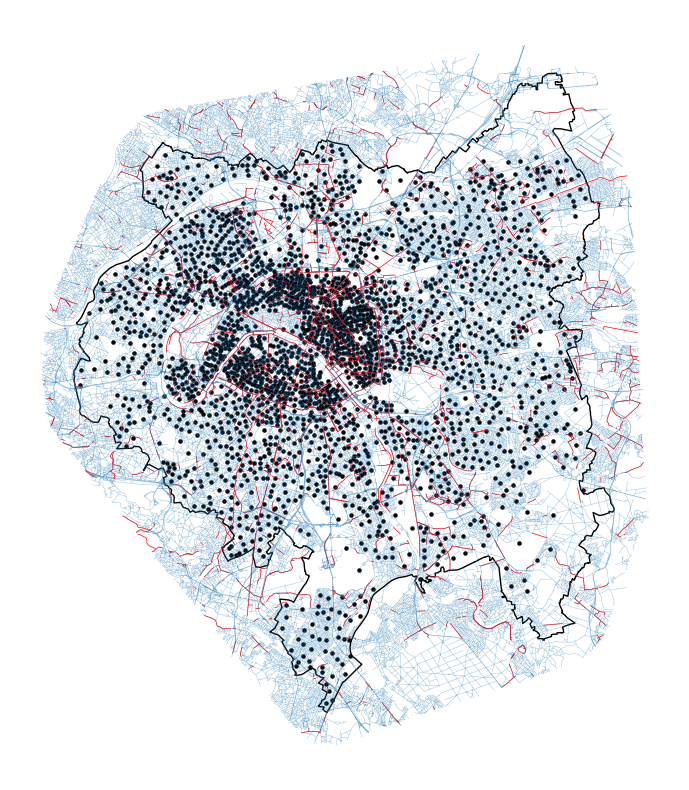

In [15]:
# Plot of bike network Vs. car network

ax = plt.axes()
plt.axis('off')
edges_with_id.loc[edges_with_id['edgetype'] == 'bike'].plot(ax=ax, linewidth = 0.5, alpha = 1, edgecolor = 'red')
edges_with_id.loc[edges_with_id['edgetype'] == 'car'].plot(ax=ax, linewidth = 0.3, alpha = 0.5)
nodes_carbike_centroids_RER_complete.loc[nodes_carbike_centroids_RER_complete['centroid'] == True].plot(ax=ax, markersize = 5, facecolor = 'black', alpha = 1)
GPM.plot(ax=ax, facecolor = 'none', edgecolor = 'black', linewidth = 1)

# Set up IGraph / NetworkX interface

In [16]:
# remove RER edges from edges_with_id

edges_with_id_with_RER = edges_with_id
edges_with_id = edges_with_id_with_RER.loc[edges_with_id_with_RER['edgetype'] != 'RER']

In [17]:
#--- Moving to igraph

# conversion to igraph
g = ig.Graph.from_networkx(G)
b = ig.Graph.from_networkx(banw)

# eids: "conversion table" for edge ids from igraph to nx 
eids_nx = [tuple(sorted(literal_eval(g.es(i)["edge_id"][0]))) for i in range(len(g.es))]
eids_ig = [i for i in range(len(g.es))]
eids_conv = pd.DataFrame({"nx": eids_nx, "ig": eids_ig})

# nids: "conversion table" for node ids from igraph to nx
nids_nx = [g.vs(i)["_nx_name"][0] for i in range(len(g.vs))]
nids_ig = [i for i in range(len(g.vs))]
nids_conv = pd.DataFrame({"nx": nids_nx, "ig": nids_ig})

# eids_conv.to_pickle("./data/pickle/eids_conv.pickle")
# nids_conv.to_pickle("./data/pickle/nids_conv.pickle")

In [67]:
%%time
### CAREFUL: THIS TAKES 1.5 HOURS!!!
# extract edge and node attributes as dictionaries

tnd = nx.get_node_attributes(H, "nodetype") # type of nodes dictionary tnd
ted = nx.get_edge_attributes(H, "edgetype") # type of edges dictionary tnd
led = nx.get_edge_attributes(H, "length") # length of edges dictionary led
cnd = nx.get_node_attributes(H, "coord") # coordinates of nodes dictionary cnd
ced = nx.get_edge_attributes(H, "coord") # coordinates of edges dictionary ced

# make data frame of ebc with:
ebc = pd.DataFrame({"edge_ig": [e.index for e in g.es]}) # igraph edge ID
ebc["edge_nx"] = ebc.apply(lambda x: tuple(literal_eval(g.es[x.edge_ig]["edge_id"])), axis = 1) # nx edge ID
ebc["length"] = ebc.apply(lambda x: g.es[x.edge_ig]["length"], axis = 1) # length in meters

# compute ebcs:
ebc["ebc_inf"] = g.edge_betweenness(directed = False, cutoff = None, weights = "length") # "standard" ebc
# ebc["ebc_lambda"] = g.edge_betweenness(directed = False, cutoff = 2500, weights = "length") # ebc only including *paths* below 2500m



CPU times: user 1h 40min 50s, sys: 27.3 s, total: 1h 41min 18s
Wall time: 1h 42min 3s


In [68]:
ebc.to_pickle("./data/pickle/ebc.pickle")


# IPDC

## Identify

In [19]:
import multiprocessing
import os
import pickle

# GET plist = LIST OF SHORTEST PATHS FOR ALL POSSIBLE CONTACT-TO-CONTACT NODE COMBINATIONS
manager = multiprocessing.Manager()
plist = manager.list()

if not os.path.exists("./data/chunks"):
    os.mkdir("./data/chunks")

# ALL CONTACT NODES FROM THE NETWORK
nodestack = [node.index for node in g.vs() if g.vs[node.index]["nodetype"] == "both"]

count = 0

def process_node(node):
    paths = g.get_shortest_paths(node, to=nodestack, weights="length", mode="out", output="epath")
    plist.extend(paths)

# Create a multiprocessing pool
pool = multiprocessing.Pool()

while nodestack:
    node = nodestack.pop()

    # Submit the process_node function to the pool for parallel execution
    pool.apply_async(process_node, args=(node,))

# Close the pool and wait for all processes to complete
pool.close()
pool.join()

# CHUNKWISE SAVING OF RESULTS (TO BE READ IN LATER)
if plist:
    with open(f"./data/chunks/c{count}.pickle", 'wb') as handle:
        pickle.dump(list(plist), handle, protocol=pickle.HIGHEST_PROTOCOL)



Process SpawnPoolWorker-449:
Traceback (most recent call last):
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_node' on <module '__mp_main__' from '/Users/auriane/Documents/GitHub/Thesis/packages.py'>
Process SpawnPoolWorker-450:
Traceback (most recent call last):
  File "/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/auriane/opt/miniconda3/

In [ ]:
# SAVING LAST CHUNK 
def save_chunk(chunk, plist):
    with open(chunk, 'wb') as handle:
        pickle.dump(plist, handle, protocol=pickle.HIGHEST_PROTOCOL)

def process_chunk(chunk, cs, mygaps):
    with open(chunk, 'rb') as f:
        pathlist = pickle.load(f)

    # adding the item to the gaplist only if it consists of only-car-edges
    gaplist = [item for item in pathlist if set(item).issubset(cs)]

    mygaps.extend(gaplist)

    del gaplist, pathlist

# cs: set of car edges
cs = set()
for edge in eids_conv["ig"]:
    if g.es[edge]["edgetype"] == "car":
        cs.add(edge)

mygaps = []

# CHUNKWISE:
mychunks = ["./data/chunks/" + filename for filename in os.listdir("./data/chunks/")]

# Create a multiprocessing pool
pool = multiprocessing.Pool()

# Process each chunk in parallel
for chunk in mychunks:
    pool.apply_async(process_chunk, args=(chunk, cs, mygaps))

# Close the pool and wait for all processes to complete
pool.close()
pool.join()

print(len(mygaps), " gaps found")

# remove chunks (not needed anymore)
for chunk in mychunks:
    os.remove(chunk)
os.rmdir("./data/chunks")


In [ ]:
# CONVERT GAPS LIST TO DF AND ADD LENGTH, ORIGIN, DESTINATION

# to df
mygaps = pd.DataFrame({"path": mygaps})

# add length
def add_length(row):
    return np.sum([g.es[edge]["length"] for edge in row.path])

mygaps["length"] = mygaps.apply(add_length, axis=1)

# add path in nx edge id
def get_path_nx(row):
    return [tuple(sorted(literal_eval(g.es[edge]["edge_id"]))) for edge in row.path]

mygaps["path_nx"] = mygaps.apply(get_path_nx, axis=1)

# add origin and destination nodes
# (separate procedure for gaps with edgenumber (enr) == 1 vs. gaps with enr > 1)
def get_origin_dest(row):
    path_nx = row.path_nx
    enr = len(path_nx)
    if enr == 1:
        o_nx = path_nx[0][0]
        d_nx = path_nx[0][1]
    else:
        o_nx = set(path_nx[0]).difference(path_nx[1]).pop()
        d_nx = set(path_nx[-1]).difference(path_nx[-2]).pop()
    return o_nx, d_nx

mygaps[["o_nx", "d_nx"]] = mygaps.apply(get_origin_dest, axis=1, result_type="expand")
mygaps.drop(columns="enr", inplace=True)

# add coordinates for plotting
ced = nx.get_edge_attributes(H, "coord")  # coordinates of edges dictionary ced

def get_path_coords(path_nx):
    return [ced[edge] for edge in path_nx]

mygaps["gapcoord"] = mygaps["path_nx"].apply(get_path_coords)

## Adding travel restrictions (OLD)
- First, attempt biking the entire way 
- Second, attempt biking to the nearest public transport, then take it, then walk to your destination
- Third, attempt walking to the nearest public transport, then take it, then walk to your destination
- If it's somehow quicker, walk all the way?!

In [1]:
# #--- Pick two random nodes to travel between
# start_node = nodes_carbike_centroids_RER_complete.sample(1)
# end_node = nodes_carbike_centroids_RER_complete.sample(1)

In [2]:
# #--- Finding the shortest path 

# try: # Attempt biking all the way
#     nx.has_path(banw, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])
#     print(nx.shortest_path(banw, source=start_node, target=end_node, weight='weight'))
# except: 
#     print('no complete bike path from start to finish')
#     try: 
#         nx.has_path(RERG, start_node['osmid'].iloc[0], end_node['osmid'].iloc[0])
#     except:
#         print('no direct RER path between both nodes')
#         path = nx.shortest_path(G, source=start_node['osmid'].iloc[0], target=end_node['osmid'].iloc[0], weight='weight')
#         for node1, node2, data in G.edges.data():
#             print(data['edgetype'])

